# MACHINE LEARNING PROJECT
### Michele Nicoletti, 1886646
### Lorenzo Pecorari, 1885161

### Environment: Taxi-v3

#Tabular solution

##Imports

In [1]:
!git clone https://github.com/LorenzoPecorari/ml-project
!mkdir trains
!mkdir neural_plots
!mkdir target_plots

import gymnasium as gym
import random

import numpy as np
import matplotlib.pyplot as plt

Cloning into 'ml-project'...
remote: Enumerating objects: 969, done.
remote: Counting objects: 100% (969/969), done.
remote: Compressing objects: 100% (773/773), done.
remote: Total 969 (delta 346), reused 695 (delta 175), pack-reused 0 (from 0)
Receiving objects: 100% (969/969), 25.69 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (346/346), done.


##Classes

###QTable

In [2]:
class QTable:
    def __init__(self, alpha, states, actions):
        self.table = np.zeros((states, actions))
        self.alpha = alpha

    def update(self, state, action, reward, next_state, gamma):
        self.table[int(state)][action] = self.table[state][action] + self.alpha * (reward + gamma * np.max(self.table[next_state]) - self.table[state][action])
        return self.table[state][action]

    def get_row(self, state):
        if(not(isinstance(state, int))):
            state = state[0]

        return self.table[state]

    def get_item(self, state, action):
        return self.table[state][action]

    def get_alpha(self):
        return self.alpha

###Agent

In [3]:
class Agent:
    def __init__(self, env, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
        self.env = env

        self.q_table = QTable(alpha, env.observation_space.n, env.action_space.n)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.rewards = []
        self.losses = []
        self.successes = []

    def choose_action(self, state):
        if(random.uniform(0, 1) < self.epsilon):
            return env.action_space.sample()
        else:
            return np.argmax(self.q_table.get_row(state))

    def update_table(self, state, action, reward, next_state):
        q = self.q_table.get_item(state, action)
        new_q = self.q_table.update(state, action, reward, next_state, self.gamma)
        loss = (new_q - q) ** 2
        return loss

    def train(self, episodes):
        for e in range(0, episodes):
            state = self.env.reset()
            done = False

            temp_reward = 0
            loss = 0
            steps = 0
            success = 0

            while(not done):
                action = self.choose_action(state)

                next_state, reward, done, truncated, _ = self.env.step(action)

                if(not(isinstance(state, int))):
                    state = state[0]

                if(not(isinstance(next_state, int))):
                    next_state = next_state[0]

                temp_reward += reward
                loss = self.update_table(state, action, reward, next_state)
                state = next_state
                steps += 1

            if not truncated:
                success = 1

            self.rewards.append(temp_reward)
            self.losses.append(np.mean(loss))
            self.successes.append(success)

            if(self.epsilon > self.epsilon_min):
                self.epsilon *= self.epsilon_decay

            if(e % 500 == 0):
                print(f"QLT - Episode: {e}, \tReward: {temp_reward}, \t\tε: {self.epsilon}")

    def plot_rewards(self):
        window = 100
        plt.figure(figsize = (10, 5))
        plt.plot(self.rewards, alpha = 0.3, color = 'green', label = "Raw Reward")
        plt.plot(range(window - 1, len(self.rewards)), np.convolve(self.rewards, np.ones(window) / window, mode = 'valid'), label = "Smoothed Rewards", color = 'green')

        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.suptitle("Reward Curve for Tabular Q-Learning")
        plt.title(f"α = {'%.4f'%self.q_table.get_alpha()}, γ = {'%.4f'%(self.gamma)}, ε = {'%.4f'%self.epsilon}, ε_min = {'%.4f'%self.epsilon_min}, ε_decay = {'%.4f'%self.epsilon_decay}")

        plt.savefig("qlt_rewards.png")
        plt.clf()

    def plot_loss(self):
        window = 10
        plt.figure(figsize = (10, 5))

        plt.plot(self.losses, alpha = 0.3, color = 'blue', label = "Raw Loss")
        plt.plot(range(window - 1, len(self.losses)), np.convolve(self.losses, np.ones(window) / window, mode = 'valid'), label = "Smoothed Loss", color = 'blue')

        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.suptitle("Loss Curve for Tabular Q-Learning")
        plt.title(f"α = {'%.4f'%self.q_table.get_alpha()}, γ = {'%.4f'%(self.gamma)}, ε = {'%.4f'%self.epsilon}, ε_min = {'%.4f'%self.epsilon_min}, ε_decay = {'%.4f'%self.epsilon_decay}")

        plt.savefig("qlt_loss.png")
        plt.clf()

    def plot_accuracy(self):
        window = 10
        accuracy = []
        tmp = 0

        for idx in range(0, len(self.successes)):
            tmp += self.successes[idx]
            accuracy.append(float(tmp / (idx + 1)))

        plt.figure(figsize = (10, 5))
        plt.plot(accuracy, alpha = 0.3, color = 'red', label = "Raw Accuracy")
        plt.plot(range(window - 1, len(accuracy)), np.convolve(accuracy, np.ones(window) / window, mode = 'valid'), label = "Smoothed Accuracy", color = 'red')

        plt.xlabel("Episode")
        plt.ylabel("Accuracy")
        plt.suptitle("Accuracy Curve for Tabular Q-Learning")
        plt.title(f"α = {'%.4f'%self.q_table.get_alpha()}, γ = {'%.4f'%(self.gamma)}, ε = {'%.4f'%self.epsilon}, ε_min = {'%.4f'%self.epsilon_min}, ε_decay = {'%.4f'%self.epsilon_decay}")

        plt.savefig("qlt_accuracy.png")
        plt.clf()

##Execution

In [ ]:
if __name__ == "__main__":
    lr = 0.001
    gamma = 0.99
    epsilon = 1.0
    epsilon_min = 0.1
    epsilon_decay = 0.998
    episodes = 8000

    env = gym.make("Taxi-v3")
    agent = Agent(env, lr, gamma, epsilon, epsilon_min, epsilon_decay)

    agent.train(episodes)
    agent.plot_rewards()
    agent.plot_loss()
    agent.plot_accuracy()

QLT - Episode: 0, 	Reward: -21634, 		ε: 0.998


### Example of plots returned by the agent using Q-Tabular:
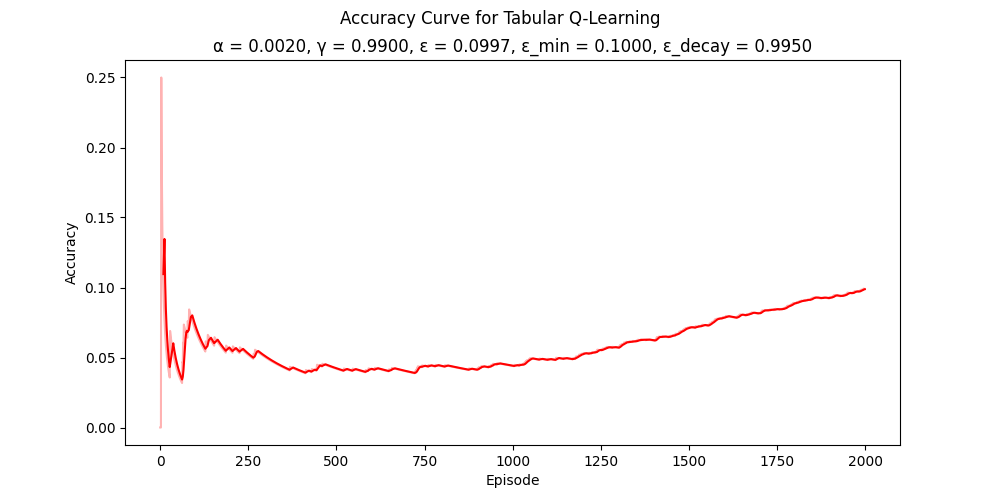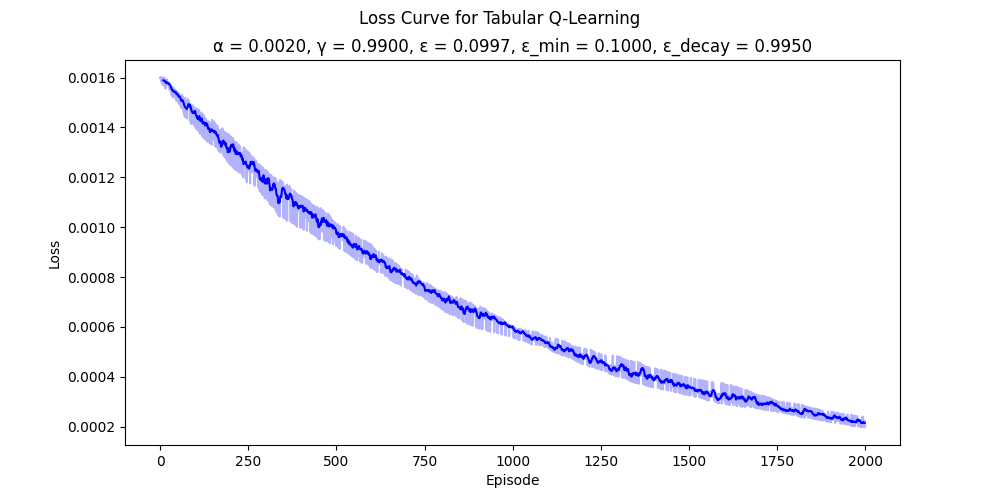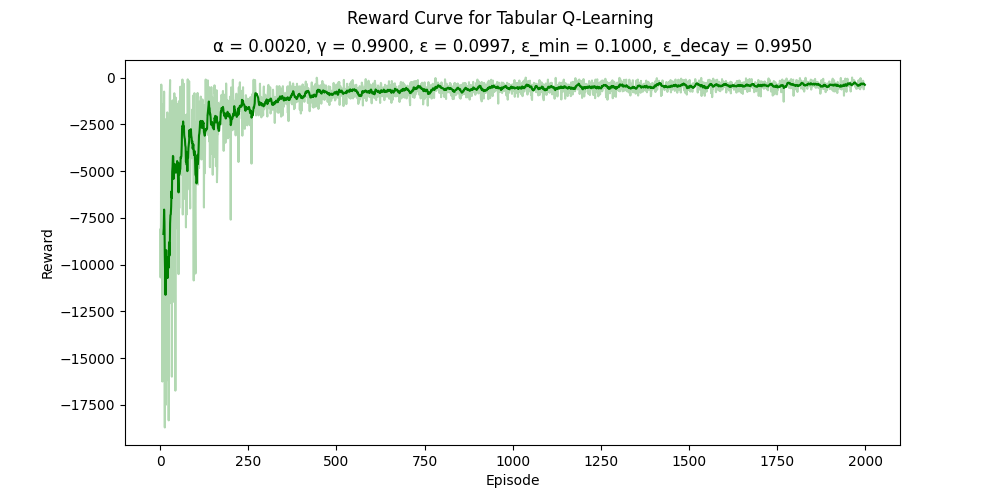

#Neural Network solution

##Imports

In [4]:
import gymnasium as gym
import random
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

import os

##Classes

###Neural Networks

In [5]:
class L3_QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(L3_QNet, self).__init__()
        self.layers=3
        self.input_layer=nn.Linear(state_dim, 64)
        self.hidden_layer=nn.Linear(64, 64)
        self.output_layer=nn.Linear(64, action_dim)

    def forward(self, state):
        out1=torch.relu(self.input_layer(state))
        out2=torch.relu(self.hidden_layer(out1))
        return self.output_layer(out2)

class L4_QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(L4_QNet, self).__init__()
        self.layers=4
        self.input_layer=nn.Linear(state_dim, 64)
        self.hidden_layer_1=nn.Linear(64, 64)
        self.hidden_layer_2=nn.Linear(64, 64)
        self.output_layer=nn.Linear(64, action_dim)

    def forward(self, state):
        out1=torch.relu(self.input_layer(state))
        out2=torch.relu(self.hidden_layer_1(out1))
        out3=torch.relu(self.hidden_layer_2(out2))
        return self.output_layer(out3)

class L5_QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(L5_QNet, self).__init__()
        self.layers=5
        self.input_layer=nn.Linear(state_dim, 64)
        self.hidden_layer_1=nn.Linear(64, 64)
        self.hidden_layer_2=nn.Linear(64, 64)
        self.hidden_layer_3=nn.Linear(64, 64)
        self.output_layer=nn.Linear(64, action_dim)

    def forward(self, state):
        out1=torch.relu(self.input_layer(state))
        out2=torch.relu(self.hidden_layer_1(out1))
        out3=torch.relu(self.hidden_layer_2(out2))
        out4=torch.relu(self.hidden_layer_3(out3))
        return self.output_layer(out4)

###Buffer

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer=deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def pick(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def sizeof(self):
        return len(self.buffer)

###Agent

In [7]:
class Agent:
    def __init__(self, layers, state_dim, action_dim, gamma, epsilon, epsilon_decay, epsilon_min, lr):
        self.state_dim=state_dim
        self.action_dim=action_dim
        self.gamma=gamma
        self.epsilon=epsilon
        self.epsilon_decay=epsilon_decay
        self.epsilon_min=epsilon_min
        self.lr=lr
        self.layers=layers
        self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

        match(layers):
            case 3:
                self.q_network=L3_QNet(state_dim, action_dim).to(self.device)
            case 4:
                self.q_network=L4_QNet(state_dim, action_dim).to(self.device)
            case 5:
                self.q_network=L5_QNet(state_dim, action_dim).to(self.device)

        self.q_network.to(self.device)
        self.optimizer=optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer=ReplayBuffer(10000)

    def update_network(self):
        self.q_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state):
        if np.random.rand()<=self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor=torch.tensor([state], dtype=torch.long, device=self.device)
                state_tensor=F.one_hot(state_tensor, num_classes=self.state_dim).float()
                q_values=self.q_network(state_tensor)
                return q_values.argmax().item()

    def replay(self, batch_size):
        if self.replay_buffer.sizeof() < batch_size:
            return None

        batch=self.replay_buffer.pick(batch_size)
        states=[item[0] for item in batch]
        actions=[item[1] for item in batch]
        rewards=[item[2] for item in batch]
        next_states=[item[3] for item in batch]
        dones=[item[4] for item in batch]

        states=torch.tensor(states, dtype=torch.long, device=self.device)
        states= F.one_hot(states, num_classes=self.state_dim).float()
        next_states=torch.tensor(next_states,  dtype=torch.long, device=self.device)
        next_states=F.one_hot(next_states, num_classes=self.state_dim).float()

        actions=torch.tensor(actions, dtype=torch.long, device=self.device)
        rewards=torch.tensor(rewards, dtype=torch.float, device=self.device)
        dones=torch.tensor(dones, dtype=torch.float, device=self.device)

        q_values=self.q_network(states)
        next_q_values=self.q_network(next_states)

        q_value=q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_value=next_q_values.max(1)[0]
        target=rewards+(self.gamma*next_q_value*(1-dones))
        loss=F.mse_loss(q_value, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def save_train(self):
        torch.save(self.q_network.state_dict(), f'./trains/{self.layers}L.pth')

    def load_train(self, filename):
        filepath = str("./ml-project/ml_colab_files/neural/trains/" + filename)
        print("Searching for " + filepath + " ...")

        print(os.path.isfile(filepath))

        if(os.path.isfile(filepath)):
            self.q_network.load_state_dict(torch.load(filepath, map_location=torch.device('cpu'), weights_only=True))

    def plot_rewards_smoothed(self, rewards, layers):
        window = 10
        smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

        plt.figure(figsize=(10, 5))
        plt.plot(rewards, alpha=0.3, label="Raw Reward")
        plt.plot(range(window - 1, len(rewards)), smoothed_rewards, label=f"Smoothed Rewards (window={window})", color='green')

        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.suptitle(f"Rewards Curve for NN with {self.layers} layers\n")
        plt.title(f"γ = {'%.4f'%(self.gamma)}, ε = {'%.4f'%(self.epsilon)}, ε_dec = {'%.4f'%(self.epsilon_decay)}, ε_min = {'%.4f'%(self.epsilon_min)}, lr = {'%.4f'%(self.lr)}")

        plt.savefig(f"./neural_plots/{layers}L_rewards.jpg")
        plt.clf()

    def plot_losses(self, losses, layers):
        window = 10
        smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='valid')

        plt.figure(figsize=(10, 5))
        plt.plot(losses, alpha=0.3, label="Raw Loss")
        plt.plot(range(window - 1, len(losses)), smoothed_losses, label=f"Smoothed Loss (window={window})", color='red')

        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.suptitle(f"Loss Curve for NN with {self.layers} layers\n")
        plt.title(f"γ = {'%.4f'%(self.gamma)}, ε = {'%.4f'%(self.epsilon)}, ε_dec = {'%.4f'%(self.epsilon_decay)}, ε_min = {'%.4f'%(self.epsilon_min)}, lr = {'%.4f'%(self.lr)}")

        plt.savefig(f"./neural_plots/{layers}L_loss.jpg")
        plt.clf()

    def plot_accuracy(self, successes):
        size = len(successes)
        tmp = 0
        accuracy = []
        window = 10

        for i in range(1, size + 1):
            tmp += successes[i-1]
            # print(f"Accuracy: {tmp/i}")
            accuracy.append(tmp/i)

        smoothed_accuracy = np.convolve(accuracy, np.ones(window)/window, mode='valid')

        plt.plot(accuracy, alpha=0.3, label="Raw Accuracy")
        plt.plot(range(window - 1, len(accuracy)), smoothed_accuracy, label=f"Smoothed Loss (window={window})", color='blue')
        plt.xlabel("Episode")
        plt.ylabel("Accuracy")
        plt.suptitle(f"Accuracy Curve for NN with {self.layers} layers\n")
        plt.title(f"γ = {'%.4f'%(self.gamma)}, ε = {'%.4f'%(self.epsilon)}, ε_dec = {'%.4f'%(self.epsilon_decay)}, ε_min = {'%.4f'%(self.epsilon_min)}, lr = {'%.4f'%(self.lr)}")

        plt.savefig(f"./neural_plots/{self.layers}L_accuracy.jpg")
        plt.clf()

##Train function

In [8]:
def train(epsiodes, gamma, epsilon, epsilon_decay, epsilon_min, lr):
    env=gym.make("Taxi-v3")

    L3_agent= Agent(layers=3,
                    state_dim=env.observation_space.n,
                    action_dim=env.action_space.n,
                    gamma=gamma,
                    epsilon=epsilon,
                    epsilon_decay=epsilon_decay,
                    epsilon_min=epsilon_min,
                    lr=lr)

    L4_agent= Agent(layers=4,
                    state_dim=env.observation_space.n,
                    action_dim=env.action_space.n,
                    gamma=gamma,
                    epsilon=epsilon,
                    epsilon_decay=epsilon_decay,
                    epsilon_min=epsilon_min,
                    lr=lr)

    L5_agent= Agent(layers=5,
                    state_dim=env.observation_space.n,
                    action_dim=env.action_space.n,
                    gamma=gamma,
                    epsilon=epsilon,
                    epsilon_decay=epsilon_decay,
                    epsilon_min=epsilon_min,
                    lr=lr)

    agents=[L3_agent, L4_agent, L5_agent]

    for a in agents:
        a.load_train(f"{a.layers}L.pth")
        rewards=[]
        losses_per_episode=[]
        successes=[]

        for e in range(epsiodes):
            state, _ =env.reset()
            done=False
            total_reward=0
            episode_losses=[]
            success=0

            while not done:
                action=a.select_action(state)
                next_state, reward, terminated, truncated, _ =env.step(action)

                if(terminated):
                    success=1

                done= terminated or truncated
                a.replay_buffer.push(state, action, reward, next_state, done)
                loss_val=a.replay(64)
                if loss_val is not None:
                    episode_losses.append(loss_val)
                state=next_state
                total_reward+=reward

            if a.epsilon>a.epsilon_min:
                a.epsilon*=a.epsilon_decay

            if len(episode_losses)>0:
                avg_loss=np.mean(episode_losses)
                losses_per_episode.append(avg_loss)
            else:
                losses_per_episode.append(0)

            successes.append(success)
            rewards.append(total_reward)

            if(e % 500 == 0):
                print(f"Agent {a.layers}L - Episode {e}, Total Reward: {total_reward}, ε: {a.epsilon:.4f}, Avg Loss: {losses_per_episode[-1]:.6f}")

        a.plot_rewards_smoothed(rewards, a.layers)
        a.plot_losses(losses_per_episode, a.layers)
        a.plot_accuracy(successes)

        a.save_train()

        successes = None
        successes = []

##Execution

In [ ]:
if __name__=="__main__":
    env=gym.make("Taxi-v3")
    state_dim=env.observation_space.n,
    action_dim=env.action_space.n,

    gamma=0.99
    epsilon=1.0
    epslion_decay=0.995
    epsilon_min=0.1
    lr=0.001
    episodes=8000
    train(episodes, gamma, epsilon, epslion_decay, epsilon_min, lr)

Searching for ./ml-project/ml_colab_files/neural/trains/3L.pth ...
True
Agent 3L - Episode 0, Total Reward: -785, ε: 0.9950, Avg Loss: 0.012097
Agent 3L - Episode 500, Total Reward: -7, ε: 0.0997, Avg Loss: 0.001808
Agent 3L - Episode 1000, Total Reward: 9, ε: 0.0997, Avg Loss: 0.000869
Agent 3L - Episode 1500, Total Reward: 10, ε: 0.0997, Avg Loss: 0.000788
Agent 3L - Episode 2000, Total Reward: 9, ε: 0.0997, Avg Loss: 0.001386
Agent 3L - Episode 2500, Total Reward: -4, ε: 0.0997, Avg Loss: 0.000772
Agent 3L - Episode 3000, Total Reward: 5, ε: 0.0997, Avg Loss: 0.001309
Agent 3L - Episode 3500, Total Reward: 7, ε: 0.0997, Avg Loss: 0.000710
Agent 3L - Episode 4000, Total Reward: 8, ε: 0.0997, Avg Loss: 0.001820
Agent 3L - Episode 4500, Total Reward: 10, ε: 0.0997, Avg Loss: 0.000816
Agent 3L - Episode 5000, Total Reward: 5, ε: 0.0997, Avg Loss: 0.000586
Agent 3L - Episode 5500, Total Reward: 13, ε: 0.0997, Avg Loss: 0.000830
Agent 3L - Episode 6000, Total Reward: -3, ε: 0.0997, Avg Lo

### Example of plots returned by the agent using Neural Network:
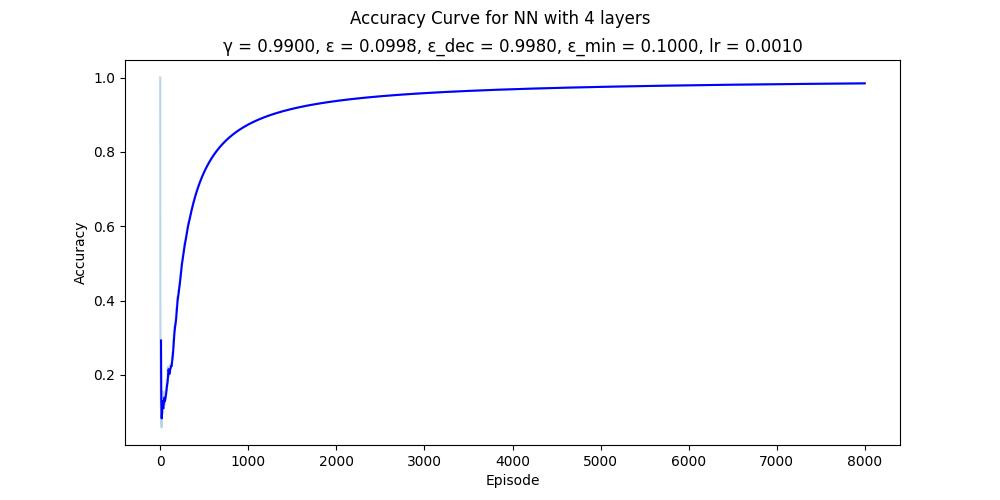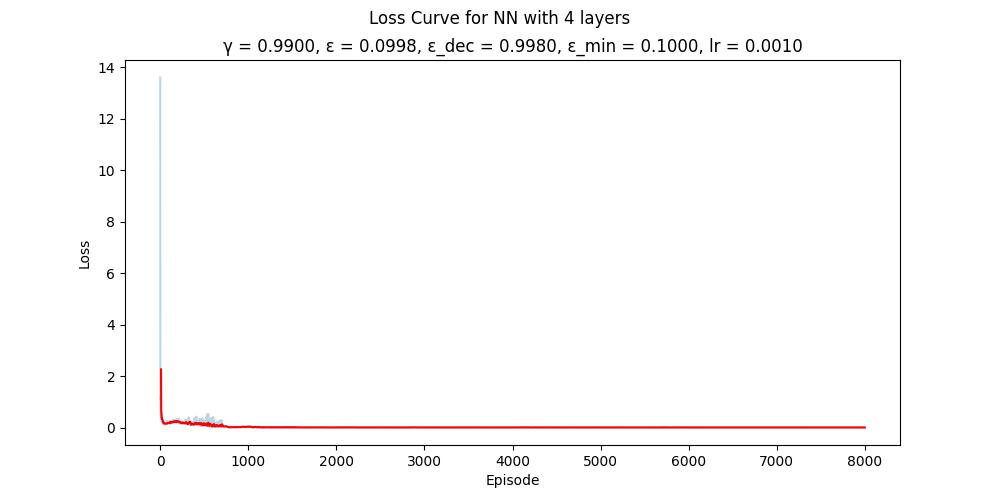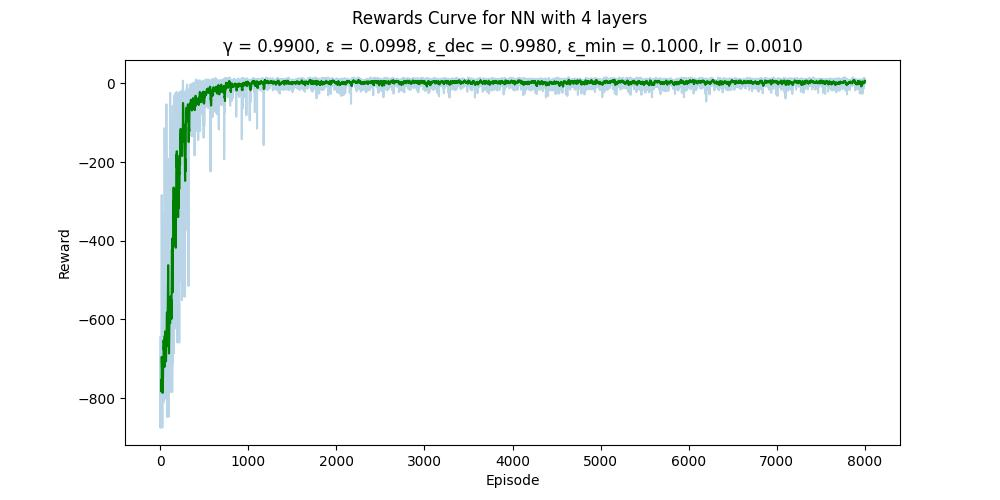

#Neural Network solution with Target Network

##Imports

In [ ]:
import gymnasium as gym
import random
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

##Classes

###Neural Networks

In [ ]:
class L3_QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(L3_QNet, self).__init__()
        self.layers = 3
        self.input_layer = nn.Linear(state_dim, 48)
        self.hidden_layer = nn.Linear(48, 48)
        self.output_layer = nn.Linear(48, action_dim)

    def forward(self, state):
        out1 = torch.relu(self.input_layer(state))
        out2 = torch.relu(self.hidden_layer(out1))
        return self.output_layer(out2)

class L4_QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(L4_QNet, self).__init__()
        self.layers = 4
        self.input_layer = nn.Linear(state_dim, 48)
        self.hidden_layer_2 = nn.Linear(48, 48)
        self.hidden_layer_1 = nn.Linear(48, 48)
        self.output_layer = nn.Linear(48, action_dim)

    def forward(self, state):
        out1 = torch.relu(self.input_layer(state))
        out2 = torch.relu(self.hidden_layer_1(out1))
        out3 = torch.relu(self.hidden_layer_2(out2))
        return self.output_layer(out3)

class L5_QNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(L5_QNet, self).__init__()
        self.layers = 5
        self.input_layer = nn.Linear(state_dim, 48)
        self.hidden_layer_1 = nn.Linear(48, 48)
        self.hidden_layer_2 = nn.Linear(48, 48)
        self.hidden_layer_3 = nn.Linear(48, 48)
        self.output_layer = nn.Linear(48, action_dim)

    def forward(self, state):
        out1 = torch.relu(self.input_layer(state))
        out2 = torch.relu(self.hidden_layer_1(out1))
        out3 = torch.relu(self.hidden_layer_2(out2))
        out4 = torch.relu(self.hidden_layer_3(out3))
        return self.output_layer(out4)

###Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def pick(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def sizeof(self):
        return len(self.buffer)

###Agent

In [ ]:
class Agent:
    def __init__(self, layers, state_dim, action_dim, gamma, epsilon, epsilon_decay, epsilon_min, lr):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.lr = lr
        self.layers = layers

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        match(layers):
            case 3:
                self.q_network = L3_QNet(state_dim, action_dim).to(self.device)
                self.target_network = L3_QNet(state_dim, action_dim).to(self.device)

            case 4:
                self.q_network = L4_QNet(state_dim, action_dim).to(self.device)
                self.target_network = L4_QNet(state_dim, action_dim).to(self.device)

            case 5:
                self.q_network = L5_QNet(state_dim, action_dim).to(self.device)
                self.target_network = L5_QNet(state_dim, action_dim).to(self.device)

        self.q_network.to(self.device)
        self.target_network.to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.replay_buffer = ReplayBuffer(10000)
        self.update_target_network()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.tensor([state], dtype=torch.long, device=self.device)
                state_tensor = F.one_hot(state_tensor, num_classes=self.state_dim).float()
                q_values = self.q_network(state_tensor)
                return q_values.argmax().item()

    def replay(self, batch_size=64):
        if self.replay_buffer.sizeof() < batch_size:
            return None

        batch = self.replay_buffer.pick(batch_size)

        states = [item[0] for item in batch]
        actions = [item[1] for item in batch]
        rewards = [item[2] for item in batch]
        next_states = [item[3] for item in batch]
        dones = [item[4] for item in batch]

        states = torch.tensor(states, dtype=torch.long, device=self.device)
        states = F.one_hot(states, num_classes=self.state_dim).float()
        next_states = torch.tensor(next_states, dtype=torch.long, device=self.device)
        next_states = F.one_hot(next_states, num_classes=self.state_dim).float()

        actions = torch.tensor(actions, dtype=torch.long, device=self.device)
        rewards = torch.tensor(rewards, dtype=torch.float, device=self.device)
        dones = torch.tensor(dones, dtype=torch.float, device=self.device)

        q_values = self.q_network(states)
        next_q_values = self.target_network(next_states)

        q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_value = next_q_values.max(1)[0]
        target = rewards + (self.gamma * next_q_value * (1 - dones))

        loss = F.mse_loss(q_value, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def save_train(self):
        torch.save(self.target_network.state_dict(), f'./trains/{self.layers}L.pth')

    def load_train(self, filename):
        filepath = str(".ml-project/ml_colab_files/target/trains/" + filename)
        print("Searching for " + filepath + " ...")

        print(os.path.isfile(filepath))

        if(os.path.isfile(filepath)):
                self.q_network.load_state_dict(torch.load(filepath, weights_only=True))
                self.target_network.load_state_dict(torch.load(filepath, weights_only=True))

    def plot_rewards_smoothed(self, rewards, layers):
        window = 10
        smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')

        plt.figure(figsize=(10, 5))
        plt.plot(rewards, alpha=0.3, label="Raw Reward")
        plt.plot(range(window - 1, len(rewards)), smoothed_rewards, label=f"Smoothed Rewards (window={window})", color='green')

        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.suptitle(f"Rewards Curve for NN with {self.layers} layers\n")
        plt.title(f"γ = {'%.4f'%(self.gamma)}, ε = {'%.4f'%(self.epsilon)}, ε_dec = {'%.4f'%(self.epsilon_decay)}, ε_min = {'%.4f'%(self.epsilon_min)}, lr = {'%.4f'%(self.lr)}")

        plt.savefig(f"./target_plots/{layers}L_rewards.jpg")
        plt.clf()

    def plot_losses(self, losses, layers):
        window = 10
        smoothed_losses = np.convolve(losses, np.ones(window)/window, mode='valid')

        plt.figure(figsize=(10, 5))
        plt.plot(losses, alpha=0.3, label="Raw Loss")
        plt.plot(range(window - 1, len(losses)), smoothed_losses, label=f"Smoothed Loss (window={window})", color='red')

        plt.xlabel("Episode")
        plt.ylabel("Loss")
        plt.suptitle(f"Loss Curve for NN with {self.layers} layers\n")
        plt.title(f"γ = {'%.4f'%(self.gamma)}, ε = {'%.4f'%(self.epsilon)}, ε_dec = {'%.4f'%(self.epsilon_decay)}, ε_min = {'%.4f'%(self.epsilon_min)}, lr = {'%.4f'%(self.lr)}")

        plt.savefig(f"./target_plots/{layers}L_loss.jpg")
        plt.clf()

    def plot_accuracy(self, successes):
        size = len(successes)
        tmp = 0
        accuracy = []
        window = 10

        for i in range(1, size + 1):
            tmp += successes[i-1]
            print(f"Accuracy: {tmp/i}")
            accuracy.append(tmp/i)

        smoothed_accuracy = np.convolve(accuracy, np.ones(window)/window, mode='valid')

        plt.plot(accuracy, alpha=0.3, label="Raw Accuracy")
        plt.plot(range(window - 1, len(accuracy)), smoothed_accuracy, label=f"Smoothed Loss (window={window})", color='blue')
        plt.xlabel("Episode")
        plt.ylabel("Accuracy")
        plt.suptitle(f"Accuracy Curve for NN with {self.layers} layers\n")
        plt.title(f"γ = {'%.4f'%(self.gamma)}, ε = {'%.4f'%(self.epsilon)}, ε_dec = {'%.4f'%(self.epsilon_decay)}, ε_min = {'%.4f'%(self.epsilon_min)}, lr = {'%.4f'%(self.lr)}")

        plt.savefig(f"./target_plots/{self.layers}L_accuracy.jpg")
        plt.clf()

##Train function

In [ ]:
def train(episodes, gamma, epsilon, epsilon_decay, epsilon_min, lr):
    env = gym.make("Taxi-v3")

    L3_agent = Agent(layers = 3,
                     state_dim=env.observation_space.n,
                     action_dim=env.action_space.n,
                     gamma = gamma,
                     epsilon = epsilon,
                     epsilon_decay= epsilon_decay,
                     epsilon_min = epsilon_min,
                     lr = lr)

    L4_agent = Agent(layers = 4,
                     state_dim=env.observation_space.n,
                     action_dim=env.action_space.n,
                     gamma = gamma,
                     epsilon = epsilon,
                     epsilon_decay= epsilon_decay,
                     epsilon_min = epsilon_min,
                     lr = lr)

    L5_agent = Agent(layers = 5,
                     state_dim=env.observation_space.n,
                     action_dim=env.action_space.n,
                     gamma = gamma,
                     epsilon = epsilon,
                     epsilon_decay= epsilon_decay,
                     epsilon_min = epsilon_min,
                     lr = lr)

    agents = [L3_agent, L4_agent, L5_agent]

    for a in agents:
        rewards = []
        losses_per_episode = []
        successes = []

        a.load_train(str(a.layers) + "L.pth")

        for e in range(episodes):
            state, _ = env.reset()
            done = False
            total_reward = 0
            episode_losses = []
            success = 0

            while not done:
                action = a.select_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)

                if(terminated):
                    success = 1

                done = terminated or truncated

                a.replay_buffer.push(state, action, reward, next_state, done)
                loss_val = a.replay(batch_size=64)
                if loss_val is not None:
                    episode_losses.append(loss_val)
                state = next_state
                total_reward += reward

            if e % 10 == 0:
                a.update_target_network()

            if len(episode_losses) > 0:
                avg_loss = np.mean(episode_losses)
                losses_per_episode.append(avg_loss)
            else:
                losses_per_episode.append(0)

            if a.epsilon > a.epsilon_min:
                a.epsilon *= a.epsilon_decay

            successes.append(success)
            rewards.append(total_reward)
            print(f"Agent {a.layers}L - Episode {e}, Total Reward: {total_reward}, ε: {a.epsilon:.4f}, Avg Loss: {losses_per_episode[-1]:.6f}")

        a.plot_rewards_smoothed(rewards, a.layers)
        a.plot_losses(losses_per_episode, a.layers)
        a.plot_accuracy(successes)

        a.save_train()

        successes = None
        successes = []

##Execution

In [ ]:
if __name__ == "__main__":
    env = gym.make("Taxi-v3")
    state_dim=env.observation_space.n,
    action_dim=env.action_space.n,

    gamma = 0.99
    epsilon = 1.0
    epsilon_decay = 0.995
    epsilon_min = 0.1
    lr = 0.001
    episodes = 8000

    train(episodes, gamma, epsilon, epsilon_decay, epsilon_min, lr)

### Example of plots returned by the agent using Neural and Target Networks:
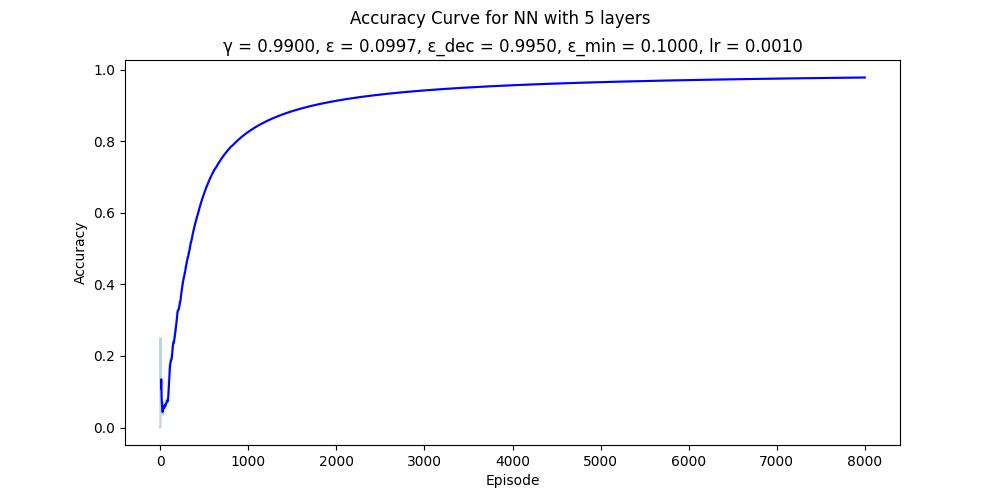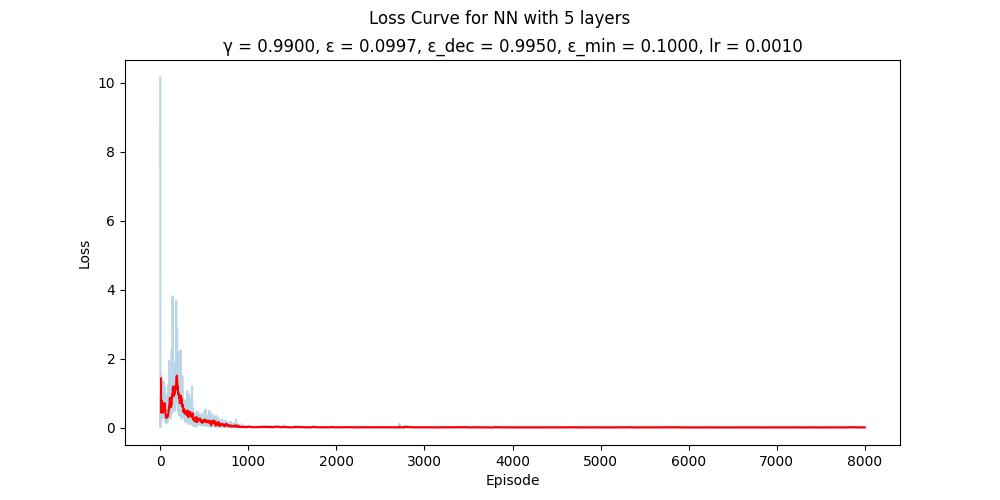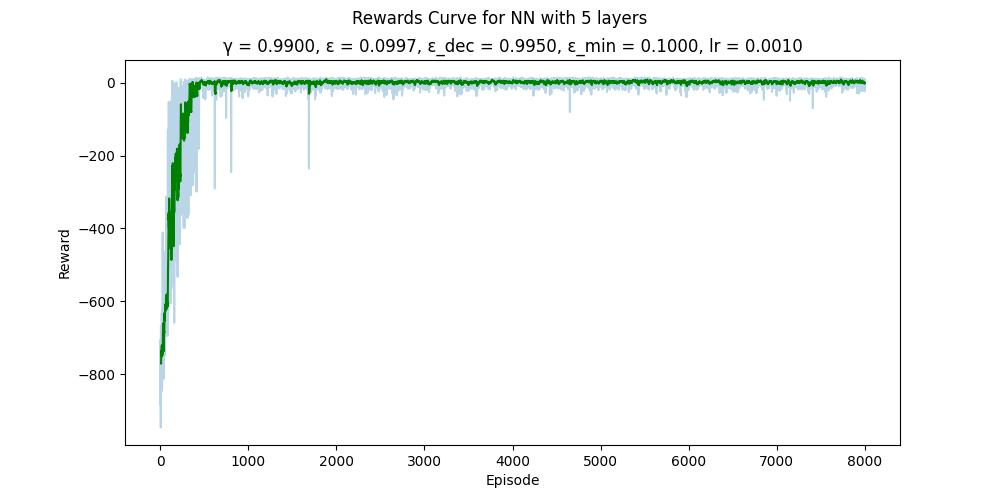